In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [4]:
from PULSE import PULSE
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import DataParallel
from pathlib import Path
from PIL import Image
import torchvision
from math import log10, ceil

In [5]:
import numpy as np
import PIL
import PIL.Image
import sys
import os
import glob
import scipy
import scipy.ndimage
import dlib
from drive import open_url
from pathlib import Path
from edge_gen import EdgeGen
import torchvision
from shape_predictor import align_face

In [6]:
import matplotlib.pyplot as plt
import collections
import stylegan
import tempfile
import subprocess

### Convert Weights
Only run once

In [92]:
from stylegan import G_synthesis, G_mapping

In [115]:
# mapping network
f = cache_dir / "g_all.pt"
t_mapping = {k[len("g_mapping."):]:v for k,v in torch.load(f).items() if k.startswith("g_mapping.")}
torch.save(t_mapping, cache_dir / "mapping.pt")

In [116]:
# synthesis network
f = cache_dir / "g_all.pt"
t_synthesis = {k[len("g_synthesis."):].replace(".top_epi", ""):v for k,v in torch.load(f).items() if k.startswith("g_synthesis.")}
torch.save(t_synthesis,  cache_dir / "synthesis.pt")

In [117]:
mapping = G_mapping()
f = cache_dir / "mapping.pt"
mapping.load_state_dict(torch.load(f))

with torch.no_grad():
    torch.manual_seed(0)
    latent = torch.randn((1000000,512),dtype=torch.float32, device="cpu")
    latent_out = torch.nn.LeakyReLU(5)(mapping(latent))
    gaussian_fit = {"mean": latent_out.mean(0), "std": latent_out.std(0)}
    torch.save(gaussian_fit,"gaussian_fit.pt")

In [124]:
batch_size = 20
lrelu = torch.nn.LeakyReLU(negative_slope=0.2)

latent = torch.randn((batch_size, 1, 512), dtype=torch.float, requires_grad=True, device='cpu')
latent_in = latent.expand(-1, 18, -1)
latent_in = lrelu(latent_in*gaussian_fit["std"] + gaussian_fit["mean"])

# Generate list of noise tensors
noise = [] # stores all of the noise tensors
noise_vars = []  # stores the noise tensors that we want to optimize on

for i in range(18):
    # dimension of the ith noise tensor
    res = (batch_size, 1, 2**(i//2+2), 2**(i//2+2))
    new_noise = torch.randn(res, dtype=torch.float, device='cpu')
    new_noise.requires_grad = False
    noise.append(new_noise)


synthesis = G_synthesis(resolution=256)
synthesis.load_state_dict(torch.load(cache_dir / "synthesis.pt"))
gen_im = (synthesis(latent_in, noise)+1)/2

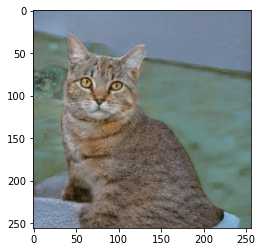

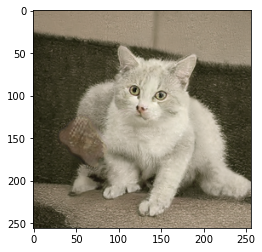

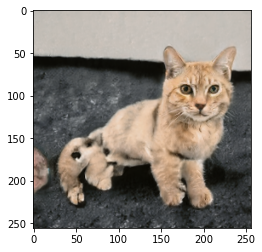

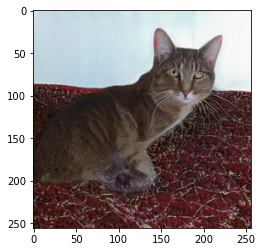

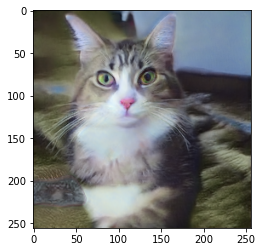

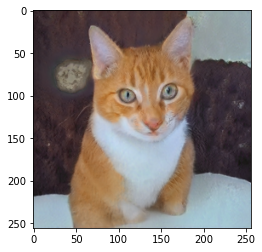

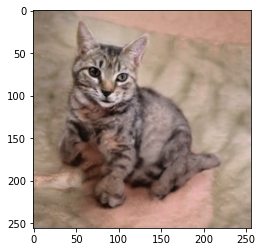

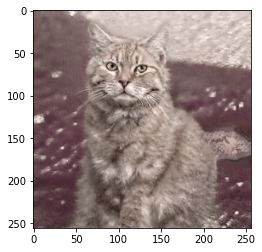

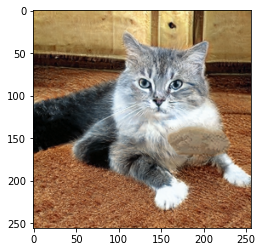

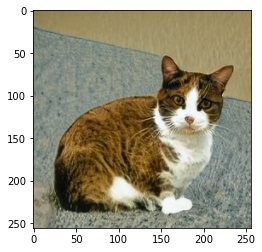

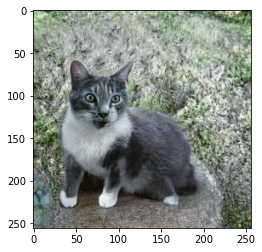

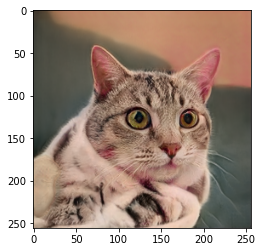

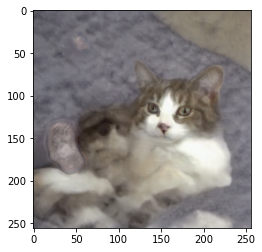

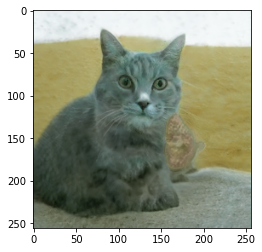

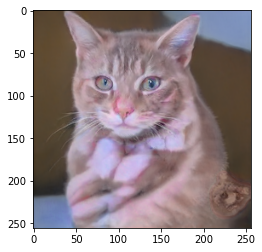

In [ ]:
from PIL import Image
generated_cats = gen_im.detach().cpu().numpy()
for i, gen_cat in zip(range(len(generated_cats)), generated_cats):
    np_image = (np.clip(gen_cat, 0, 1).transpose(1, 2, 0) * 255).astype(np.uint8)
    image = Image.fromarray(np_image)
    plt.imshow((np.clip(gen_cat, 0, 1).transpose(1, 2, 0) * 255).astype(np.uint8))
    plt.show()

### Setup Everything

In [89]:
kwargs = dict(
    input_dir="sketches/1pixel",  # 'input data directory'
    output_dir='runs',  # 'output data directory'
    cache_dir='cache',  # 'cache directory for model weights'
    duplicates=1,  # 'How many HR images to produce for every image in the input directory'
    batch_size=1,  # 'Batch size to use during optimization'
    seed=0,  # 'manual seed to use'
    loss_str="100*L2+0.05*GEOCROSS",  # 'Loss function to use'
    eps=2e-3,  # 'Target for downscaling loss (L2)'
    noise_type='trainable',  # 'zero, fixed, or trainable'
    num_trainable_noise_layers=5,  # 'Number of noise layers to optimize'
    tile_latent=False,  # 'Whether to forcibly tile the same latent 18 times'
    bad_noise_layers="17",  # 'List of noise layers to zero out to improve image quality')
    opt_name='custom',  # 'Optimizer to use in projected gradient descent'
    learning_rate=0.4,  #  help='Learning rate to use during optimization'
    steps=200,  # 'Number of optimization steps'
    lr_schedule='linear1cycledrop',  # 'fixed, linear1cycledrop, linear1cycle'
    save_intermediate=False,  # 'Whether to store and save intermediate HR and LR images during optimization'
) 

In [91]:
class Images(Dataset):
    def __init__(self, root_dir, duplicates):
        self.root_path = Path(root_dir)
        self.image_list = list(self.root_path.glob("*.png"))
        self.duplicates = duplicates # Number of times to duplicate the image in the dataset to produce multiple HR images
        factor = 1024 // 32
        self.D = EdgeGen(factor=factor)

    def __len__(self):
        return self.duplicates*len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx//self.duplicates]
        image = torchvision.transforms.ToTensor()(Image.open(img_path))
        # HACK
        if image.shape == (3, 1024, 1024):
            image = self.D(image.unsqueeze(0).cuda())[0].cpu().detach().clamp(0, 1)
        elif image.shape == (3, 32, 32):
            # already resized (:
            pass
        else:
            raise ValueError(image.shape)
        if(self.duplicates == 1):
            return image,img_path.stem
        else:
            return image,img_path.stem+f"_{(idx % self.duplicates)+1}"

dataset = Images(kwargs["input_dir"], duplicates=kwargs["duplicates"])
out_path = Path(kwargs["output_dir"])
out_path.mkdir(parents=True, exist_ok=True)

dataloader = DataLoader(dataset, batch_size=kwargs["batch_size"])

model = PULSE(cache_dir=kwargs["cache_dir"], resolution=256)
# removed because of error:
# TypeError: forward() missing 1 required positional argument: 'ref_im'
# model = DataParallel(model)

toPIL = torchvision.transforms.ToPILImage()

Loading Synthesis Network
